<a href="https://colab.research.google.com/github/Tzutzu13/Final_Project2020/blob/master/7_6_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing neccesary libraries and functions

In [14]:
cd /content/drive/Shared drives/USV RECORDINGS/

/content/drive/Shared drives/USV RECORDINGS


In [15]:
from __future__ import print_function
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D,Input,LeakyReLU,MaxPooling2D,Dropout,Lambda,add,Activation,Concatenate,Dense,Flatten,Conv2D
from keras.utils import plot_model
from keras.models import Model
# from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import seaborn as sns
def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
    from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    return [rlop, es, cp]
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(5,5)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)
def Remove_None_Data_and_lowering_Labels(data,labels):
    data = [j for i,j in enumerate(data) if j is not None] 
    labels= [j for i,j in enumerate(labels) if j is not None] 
    labels = [str(i) for i in labels]
    labels = [i.lower() for i in labels]
    return data, labels
def build_model(num_classes = 2):
    inp = Input(shape=(img_rows, img_cols,1))
    x = Conv2D(32, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x)
    return Model(inputs=inp, outputs=x)
def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.legend(['loss','val_loss'])
    plt.figure()
    plt.plot(hist.history['accuracy'], 'r', hist.history['val_accuracy'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend(['accuracy','val_accuracy'])
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title([i])
        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)))
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    # plt.show()
    fig.suptitle(title)


# **Loading Data and build model**

In [ ]:
# %matplotlib qt5
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)
Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Composite_syl)))

model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
plot_model(model)


#trying united syllables
freq_two = np.concatenate((Frequency_steps_syl,two_syllable_syl))
complex_chevron_flat = np.concatenate((Chevron_syl,Complex_syl,flat_syl))

freq_two_Labels = np.zeros((len(freq_two)))
complex_chevron_flat_Labels = np.ones((len(complex_chevron_flat)))

# **Complex vs Freq**

In [20]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 556, 1042]))
(array([0., 1.]), array([123, 205]))
(array([0., 1.]), array([126, 215]))
Train on 1598 samples, validate on 328 samples
Epoch 1/200
1598/1598 [==============================] - 2s 1ms/step - loss: 0.7011 - accuracy: 0.6446 - val_loss: 0.6218 - val_accuracy: 0.6311
Epoch 2/200
1598/1598 [==============================] - 1s 821us/step - loss: 0.6298 - accuracy: 0.6527 - val_loss: 0.6108 - val_accuracy: 0.6250
Epoch 3/200
1598/1598 [==============================] - 1s 817us/step - loss: 0.6111 - accuracy: 0.6546 - val_loss: 0.6158 - val_accuracy: 0.6280
Epoch 4/200
1598/1598 [==============================] - 1s 811us/step - loss: 0.5920 - accuracy: 0.6552 - val_loss: 0.5982 - val_accuracy: 0.6280
Epoch 5/200
1598/1598 [==============================] - 1s 813us/step - loss: 0.5570 - accuracy: 0.6583 - val_loss: 0.5832 - val_accuracy: 0.6311
Epoch 6/200
1598/1598 [==============================] - 1s 815us/step - loss: 0.5614 - accuracy: 0.6977 - 

(array([0, 1]), array([124, 217]))


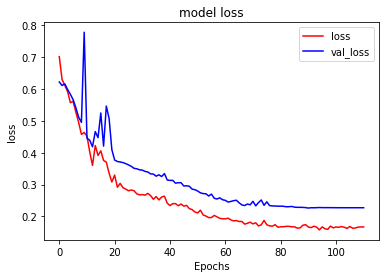

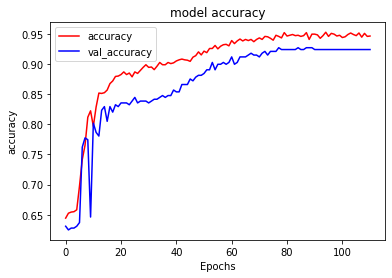

In [21]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

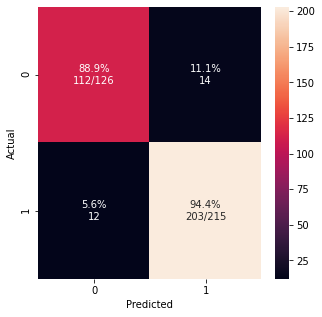

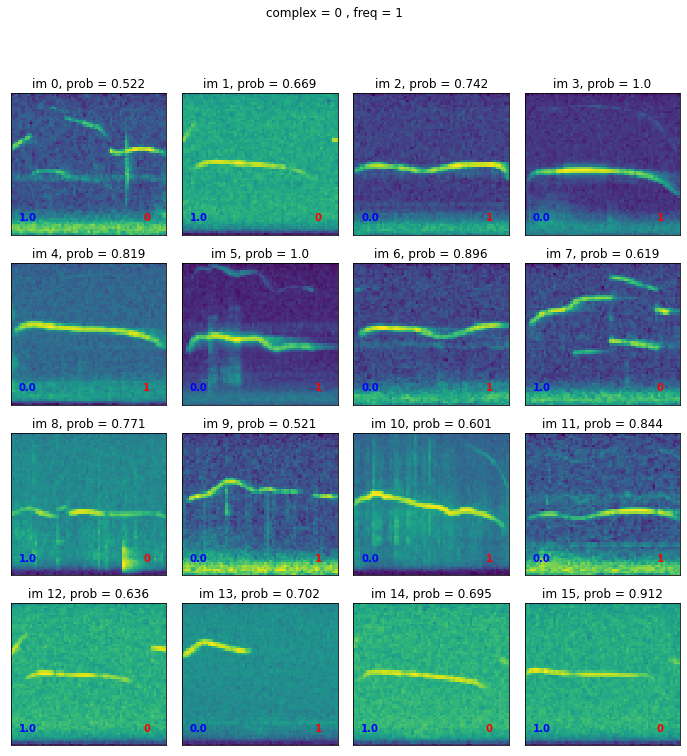

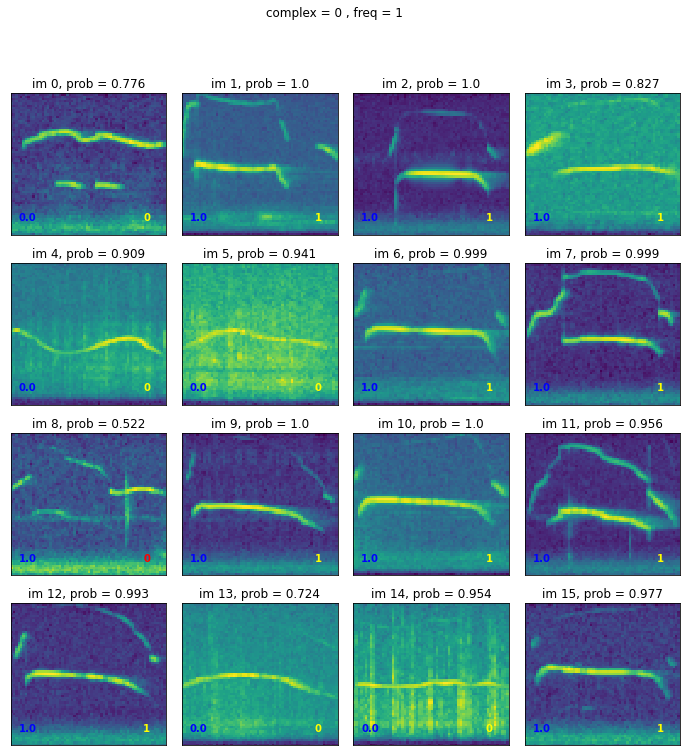

In [22]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Complex vs Freq with data augmentation**

---



In [23]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 556, 1042]))
(array([0., 1.]), array([123, 205]))
(array([0., 1.]), array([126, 215]))
Epoch 1/200
13/12 [===============================] - 2s 149ms/step - loss: 0.7424 - accuracy: 0.6245 - val_loss: 0.5975 - val_accuracy: 0.6250
Epoch 2/200
13/12 [===============================] - 1s 104ms/step - loss: 0.6156 - accuracy: 0.6508 - val_loss: 0.6178 - val_accuracy: 0.6280
Epoch 3/200
13/12 [===============================] - 1s 104ms/step - loss: 0.6034 - accuracy: 0.6527 - val_loss: 0.6023 - val_accuracy: 0.6280
Epoch 4/200
13/12 [===============================] - 1s 104ms/step - loss: 0.5977 - accuracy: 0.6546 - val_loss: 0.5986 - val_accuracy: 0.6280
Epoch 5/200
13/12 [===============================] - 1s 105ms/step - loss: 0.5740 - accuracy: 0.6627 - val_loss: 0.5791 - val_accuracy: 0.6341
Epoch 6/200
13/12 [===============================] - 1s 103ms/step - loss: 0.5559 - accuracy: 0.6952 - val_loss: 0.5993 - val_accuracy: 0.6280
Epoch 7/200
13/12 [====

(array([0, 1]), array([121, 220]))


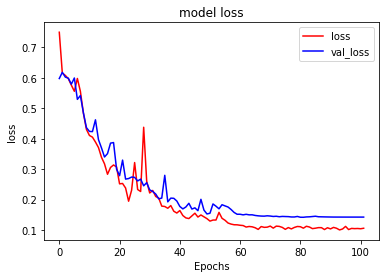

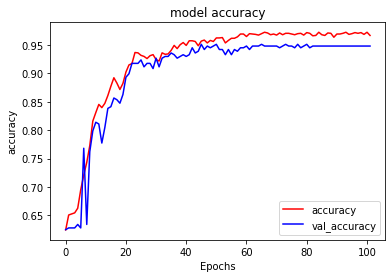

In [24]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

IndexError: ignored

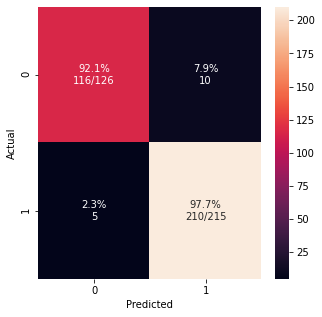

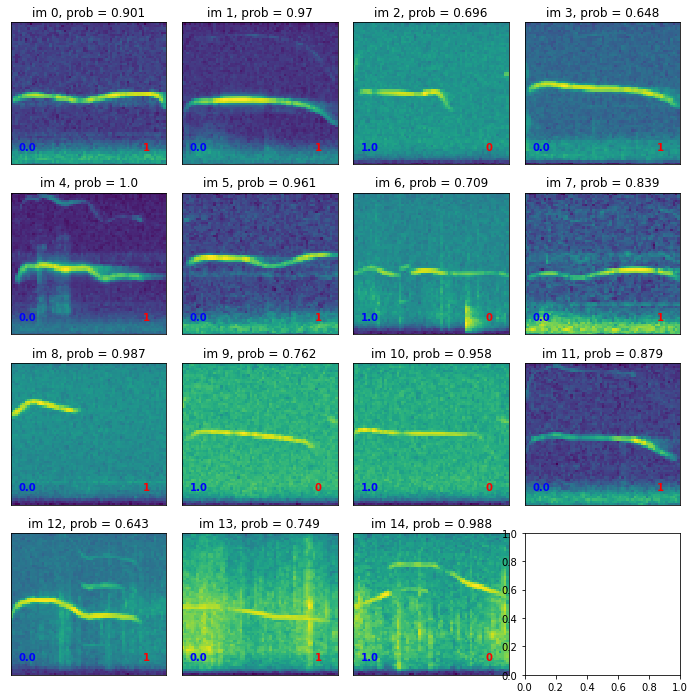

In [25]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Complex_Chevron_Flat Vs Frequency_Two syll**

In [38]:
complex_chevron_flat = np.concatenate((Chevron_syl,Complex_syl,flat_syl))
freq_two = np.concatenate((Frequency_steps_syl,two_syllable_syl))

complex_chevron_flat_Labels = np.zeros((len(complex_chevron_flat)))
freq_two_Labels = np.ones((len(freq_two)))


In [39]:
x = np.concatenate((freq_two,complex_chevron_flat))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((freq_two_Labels,complex_chevron_flat_Labels))  
x = x.astype('float32')
x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([1369, 1335]))
(array([0., 1.]), array([275, 279]))
(array([0., 1.]), array([260, 315]))
Train on 2704 samples, validate on 554 samples
Epoch 1/200
2704/2704 [==============================] - 3s 967us/step - loss: 0.6926 - accuracy: 0.6583 - val_loss: 0.7663 - val_accuracy: 0.6877
Epoch 2/200
2704/2704 [==============================] - 2s 816us/step - loss: 0.6569 - accuracy: 0.6868 - val_loss: 0.6411 - val_accuracy: 0.6480
Epoch 3/200
2704/2704 [==============================] - 2s 812us/step - loss: 0.6158 - accuracy: 0.7045 - val_loss: 0.6293 - val_accuracy: 0.6661
Epoch 4/200
2704/2704 [==============================] - 2s 817us/step - loss: 0.6160 - accuracy: 0.7219 - val_loss: 0.5792 - val_accuracy: 0.6823
Epoch 5/200
2704/2704 [==============================] - 2s 807us/step - loss: 0.5767 - accuracy: 0.7337 - val_loss: 0.5794 - val_accuracy: 0.6805
Epoch 6/200
2704/2704 [==============================] - 2s 811us/step - loss: 0.5328 - accuracy: 0.7559 

(array([0, 1]), array([281, 294]))


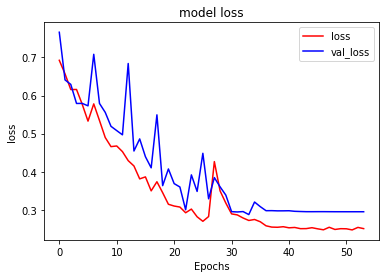

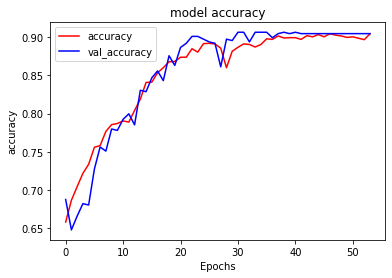

In [40]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

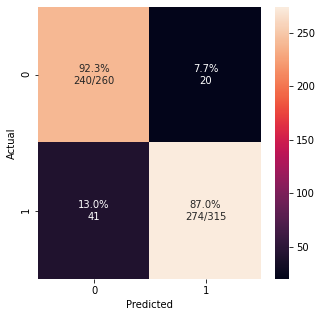

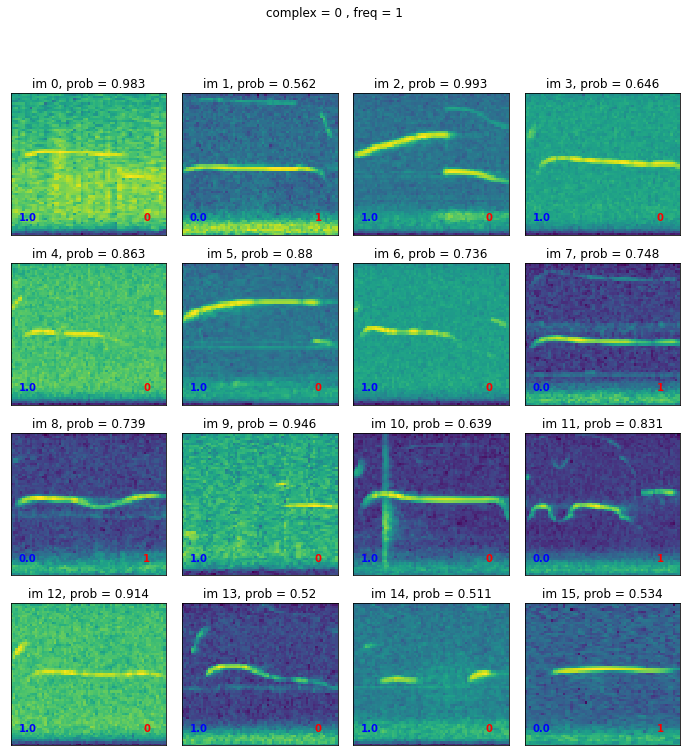

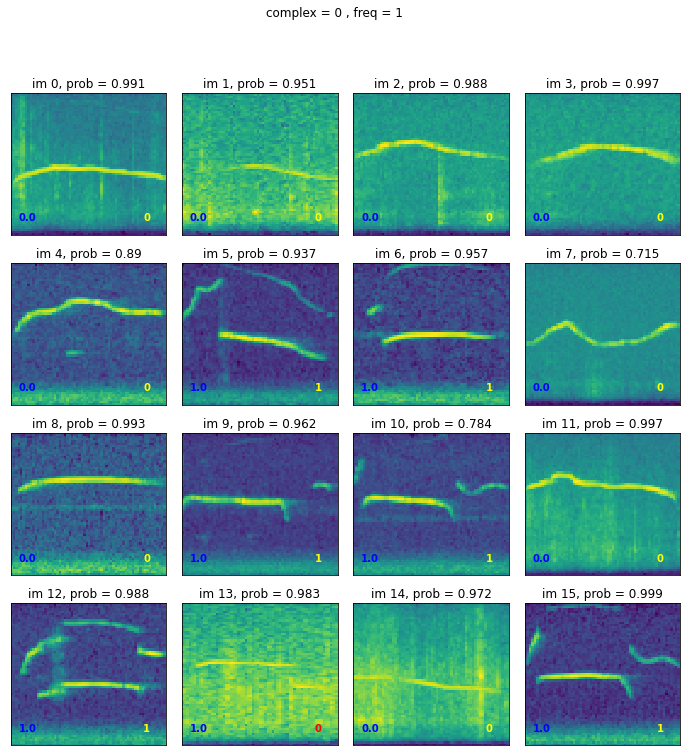

In [41]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Complex_Chevron_Flat Vs Frequency_Two syll with data augmentation**

---



---



In [42]:
x = np.concatenate((freq_two,complex_chevron_flat))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((freq_two_Labels,complex_chevron_flat_Labels))  
x = x.astype('float32')
x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([1369, 1335]))
(array([0., 1.]), array([275, 279]))
(array([0., 1.]), array([260, 315]))
Epoch 1/200
22/21 [===============================] - 3s 136ms/step - loss: 0.7053 - accuracy: 0.6716 - val_loss: 0.6370 - val_accuracy: 0.6823
Epoch 2/200
22/21 [===============================] - 2s 102ms/step - loss: 0.6411 - accuracy: 0.6601 - val_loss: 0.6696 - val_accuracy: 0.6606
Epoch 3/200
22/21 [===============================] - 2s 102ms/step - loss: 0.7077 - accuracy: 0.6716 - val_loss: 0.6694 - val_accuracy: 0.7004
Epoch 4/200
22/21 [===============================] - 2s 106ms/step - loss: 0.6173 - accuracy: 0.6720 - val_loss: 0.6663 - val_accuracy: 0.6643
Epoch 5/200
22/21 [===============================] - 2s 106ms/step - loss: 0.5935 - accuracy: 0.7223 - val_loss: 0.6324 - val_accuracy: 0.7383
Epoch 6/200
22/21 [===============================] - 2s 104ms/step - loss: 0.5739 - accuracy: 0.7482 - val_loss: 0.5622 - val_accuracy: 0.7202
Epoch 7/200
22/21 [====

(array([0, 1]), array([279, 296]))


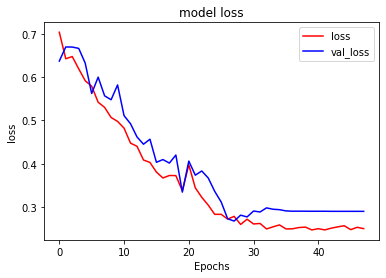

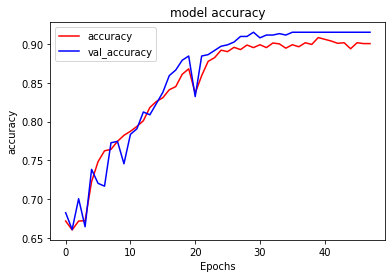

In [43]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

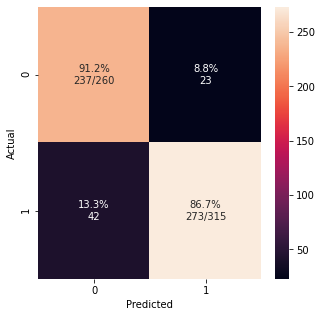

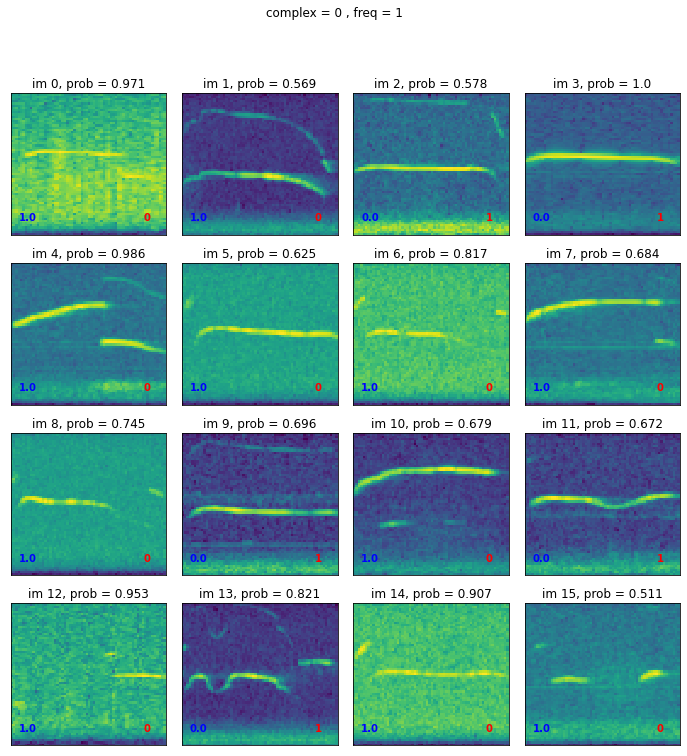

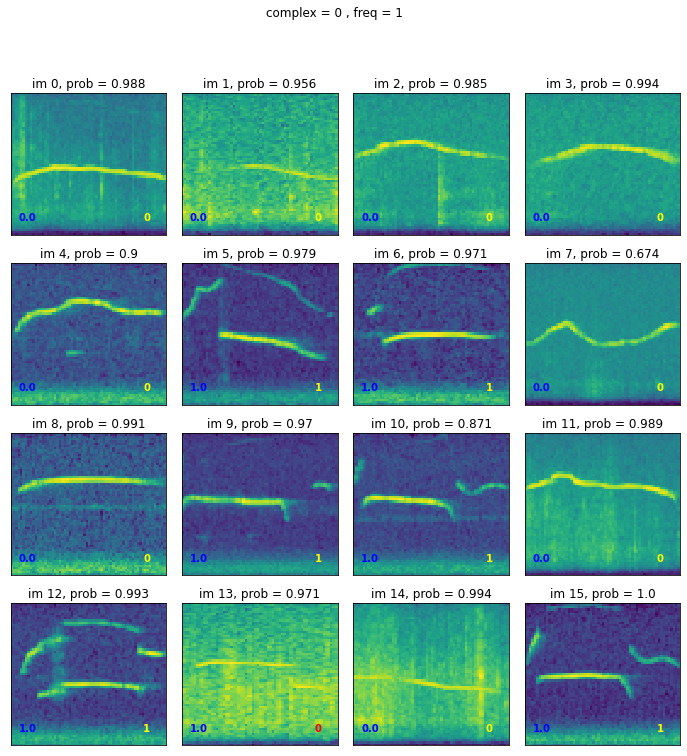

In [44]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'complex = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Freq Vs Chevron**

In [45]:
Chevron_Labels = np.zeros((len(Chevron_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
x = np.concatenate((Chevron_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((Chevron_Labels,freq_Labels))  
x = x.astype('float32')
x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 617, 1020]))
(array([0., 1.]), array([108, 228]))
(array([0., 1.]), array([135, 214]))
Train on 1637 samples, validate on 336 samples
Epoch 1/200
1637/1637 [==============================] - 2s 1ms/step - loss: 0.6863 - accuracy: 0.6103 - val_loss: 0.6850 - val_accuracy: 0.6845
Epoch 2/200
1637/1637 [==============================] - 1s 810us/step - loss: 0.5716 - accuracy: 0.6335 - val_loss: 0.4792 - val_accuracy: 0.6935
Epoch 3/200
1637/1637 [==============================] - 1s 812us/step - loss: 0.5585 - accuracy: 0.7233 - val_loss: 0.5049 - val_accuracy: 0.7768
Epoch 4/200
1637/1637 [==============================] - 1s 805us/step - loss: 0.5786 - accuracy: 0.7294 - val_loss: 0.4516 - val_accuracy: 0.7530
Epoch 5/200
1637/1637 [==============================] - 1s 812us/step - loss: 0.6458 - accuracy: 0.7330 - val_loss: 0.4901 - val_accuracy: 0.7083
Epoch 6/200
1637/1637 [==============================] - 1s 811us/step - loss: 0.5396 - accuracy: 0.7019 - 

(array([0, 1]), array([140, 209]))


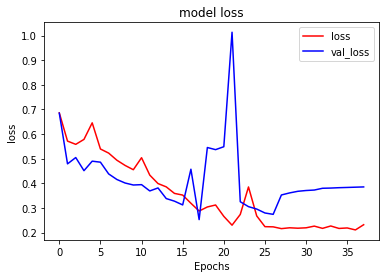

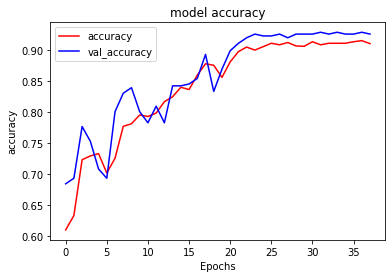

In [46]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

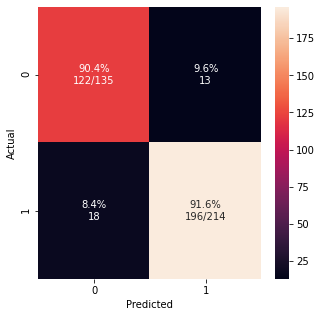

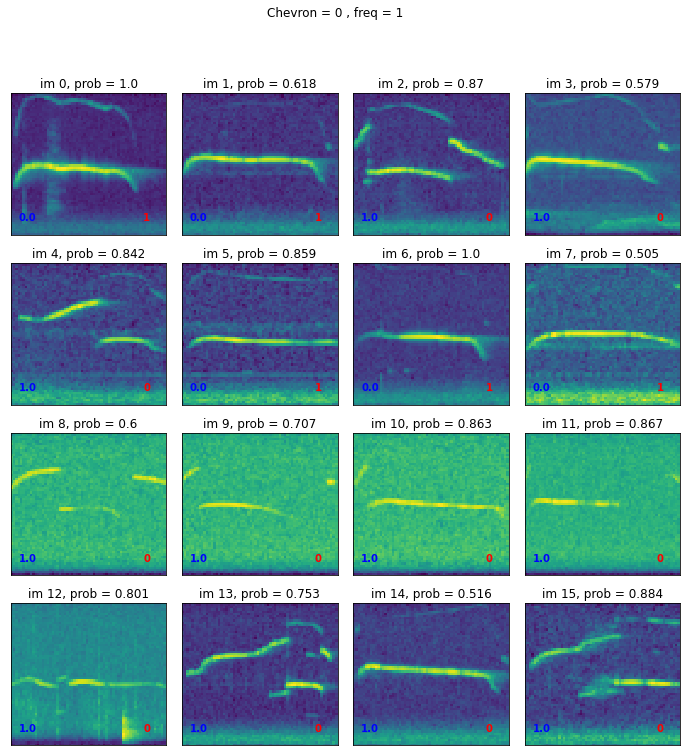

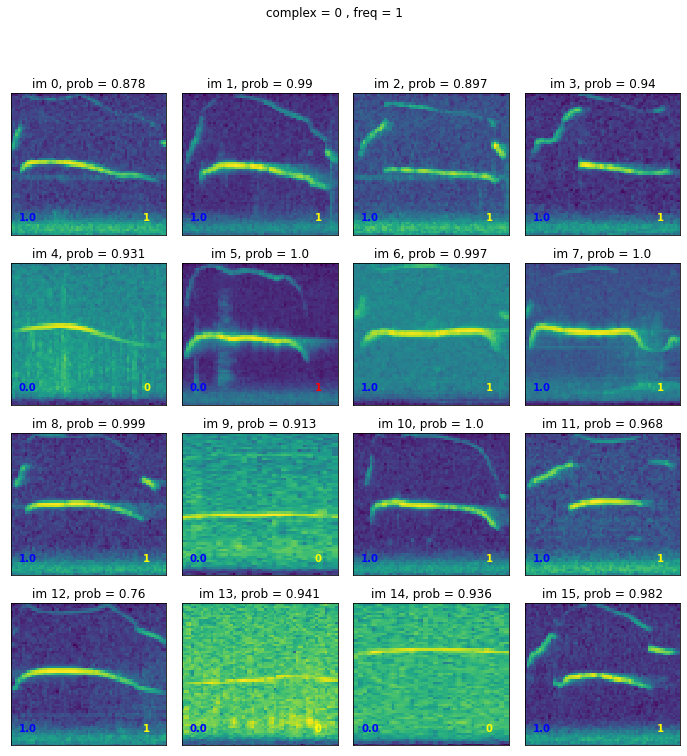

In [47]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)


# **Freq Vs Chevron with data augmentation**

---



In [48]:
Chevron_Labels = np.zeros((len(Chevron_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
x = np.concatenate((Chevron_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((Chevron_Labels,freq_Labels))  
x = x.astype('float32')
x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 617, 1020]))
(array([0., 1.]), array([108, 228]))
(array([0., 1.]), array([135, 214]))
Epoch 1/200
13/12 [==============================] - 2s 157ms/step - loss: 0.6450 - accuracy: 0.6097 - val_loss: 0.7439 - val_accuracy: 0.6815
Epoch 2/200
13/12 [==============================] - 1s 103ms/step - loss: 0.5850 - accuracy: 0.6347 - val_loss: 0.5015 - val_accuracy: 0.7232
Epoch 3/200
13/12 [==============================] - 1s 105ms/step - loss: 0.6083 - accuracy: 0.7080 - val_loss: 0.4911 - val_accuracy: 0.7857
Epoch 4/200
13/12 [==============================] - 1s 106ms/step - loss: 0.5487 - accuracy: 0.7190 - val_loss: 0.4710 - val_accuracy: 0.8244
Epoch 5/200
13/12 [==============================] - 1s 106ms/step - loss: 0.5231 - accuracy: 0.7318 - val_loss: 0.4305 - val_accuracy: 0.7887
Epoch 6/200
13/12 [==============================] - 1s 105ms/step - loss: 0.5798 - accuracy: 0.7557 - val_loss: 0.4342 - val_accuracy: 0.7440
Epoch 7/200
13/12 [==========

(array([0, 1]), array([136, 213]))


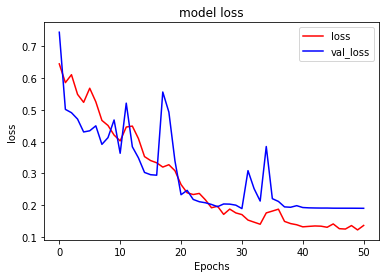

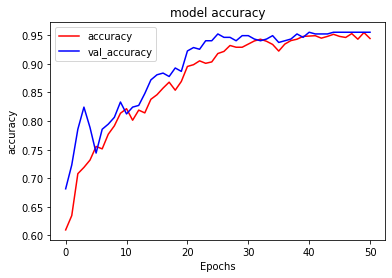

In [49]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

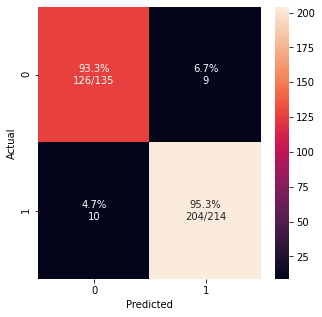

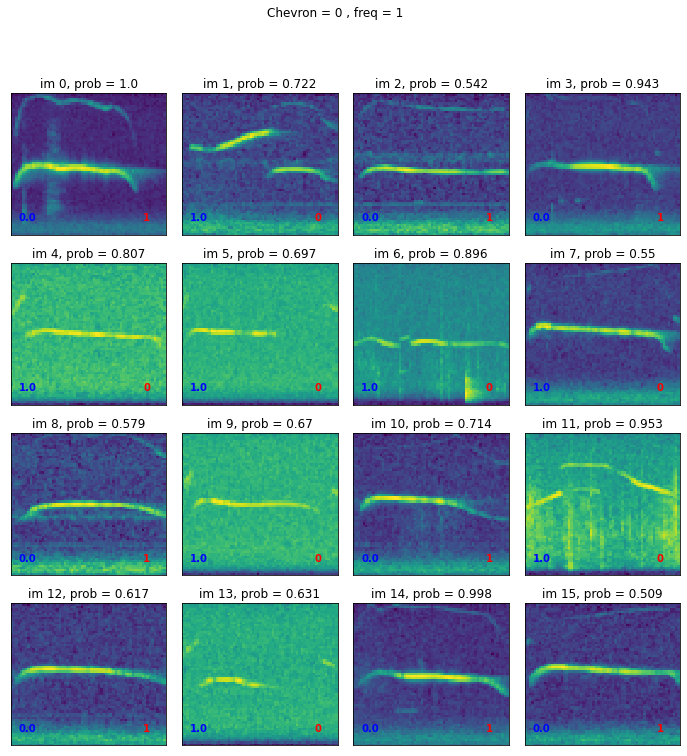

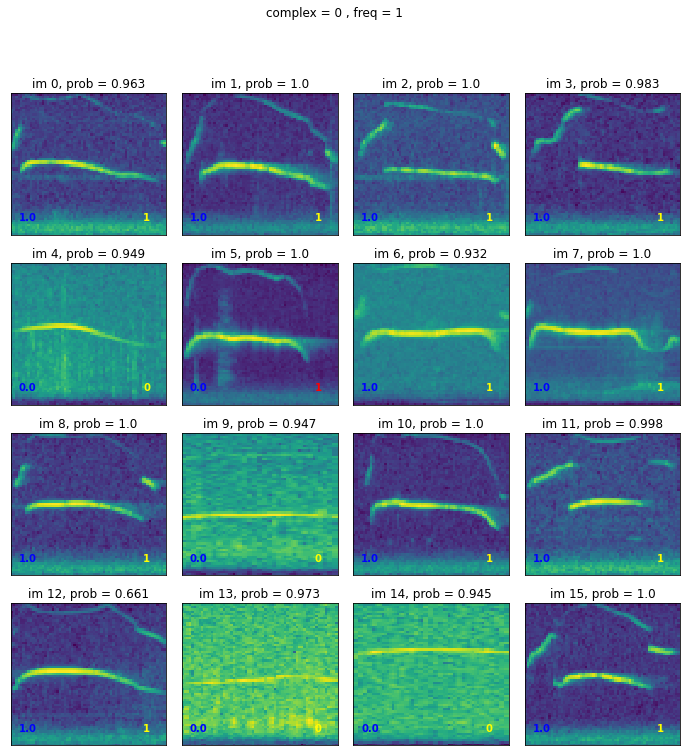

In [50]:
cm_analysis(y_test, pred, 'confusion matrix', [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,4,4,(12,12),c_pred,title = 'Chevron = 0 , freq = 1',prob = c_prob)
# plot_multiple_imgs(c_x_test,c_test,5,5,(12,12),c_pred,title = 'freq = 0 , complex = 1, noise = 2, composite = 3, harmonic = 4')
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,4,4,(12,12),pred,title = 'complex = 0 , freq = 1',prob = predictions)
